In [1]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
import sklearn.datasets
import matplotlib.pyplot as plt

import torch.functional as F

In [65]:
# import dataset
from sklearn.model_selection import train_test_split
data = pd.read_csv("slump_test.csv")
X = torch.FloatTensor(data.iloc[:, 1:10].values)
y = torch.FloatTensor(data.iloc[:, 10].values)

means = X.mean(dim=0, keepdim=True)
stds = X.std(dim=0, keepdim=True)
X = (X - means) / stds

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.76, random_state=1)
print('Average: {}, Standard Deviation: {}'.format(means, stds))

Average: tensor([[229.8942,  77.9738, 149.0146, 197.1680,   8.5398, 883.9785, 739.6048,
          18.0485,  49.6107]]), Standard Deviation: tensor([[78.8772, 60.4614, 85.4181, 20.2082,  2.8075, 88.3914, 63.3421,  8.7508,
         17.5686]])


In [126]:
data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


# Neural Network

In [6]:
def test_loss(X_test):
    model.eval()
    output = model(X_test)
    loss = sklearn.metrics.mean_squared_error(output.detach().numpy(), y_test.unsqueeze(1).detach().numpy())
    return loss.item()

def eval_model(X, y):
    model.eval()
    y_preds = model(X).detach().numpy()
    return sklearn.metrics.r2_score(y, y_preds), np.sqrt(sklearn.metrics.mean_squared_error(y, y_preds))

In [9]:
# create MLP from literature
class ConcreteNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.input_layer = nn.Linear(9, 9)     
    self.hidden_layer = nn.Linear(9, 9)
    self.output_layer = nn.Linear(9, 1) 
    self.activation = nn.Sigmoid()      

  def forward(self, x):
    x = self.input_layer(x)
    x = self.activation(x)
    x = self.hidden_layer(x)
    x = self.activation(x)
    x = self.output_layer(x)
    return x

Train R2: 0.9334669923105378, Train RMSE: 1.9554795026779175
Test R2: 0.8524335960614137, Test RMSE: 3.1365151405334473


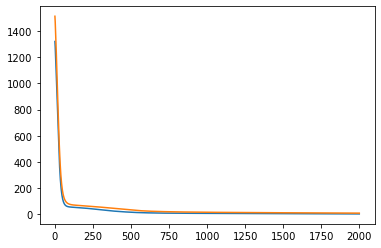

In [10]:
model = ConcreteNN()
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
epochs = 2000
loss_over_time = []
test_loss_over_time = []
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    target = y_train.unsqueeze(1)
    loss = criterion(output, target)
    loss_over_time.append(loss.item())

    test_loss_over_time.append(test_loss(X_test))

    loss.backward()
    optimizer.step()


plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = eval_model(X_test, y_test)
train_r2, train_rmse = eval_model(X_train, y_train)
print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

In [11]:
# Netz mit 50 Zufallsinitialisierungen laufen lassen
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []

for i in range(50):
    model = ConcreteNN()
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    
print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/50, sum(train_rmse_list)/50))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/50, sum(test_rmse_list)/50))

Train R2: 0.9335708943569831, Train RMSE: 1.9531769967079162
Test R2: 0.8509789539130022, Test RMSE: 3.1514614152908327


In [12]:
# test with cv k = 10
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNN()
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2 CV: {}'.format(train_r2_list))
print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2 CV: {}'.format(test_r2_list))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

    

Train R2 CV: [0.9365665508169131, 0.9381206726858291, 0.9186301664297181, 0.937422354732493, 0.9239608380978261, 0.9241515486648064, 0.9389983795838839, 0.9280217569389932, 0.93198668902406, 0.914228470235457]
Train R2: 0.929208742720998, Train RMSE: 2.064258134365082
Test R2 CV: [0.8740753489806786, 0.7612450709274932, 0.9121078601875839, 0.8151181016990399, 0.8004768281092081, 0.9432856609794031, 0.8589828742949475, 0.7845294115448191, 0.7863367527578582, 0.6911063053136529]
Test R2: 0.8227264214794685, Test RMSE: 2.5499496459960938


# Informed Machine Learning: Custom Loss Function

[16.042206]


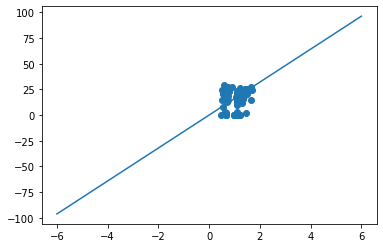

In [135]:
# linear regression
import sklearn.linear_model
WZ = torch.FloatTensor(data.iloc[:, [1, 4]].values)
W = (WZ[:, 1]/WZ[:, 0]).reshape(-1, 1) # Water/Cement
ones = torch.ones(W.shape)
#W = torch.hstack((ones, W))
s = torch.FloatTensor(data.iloc[:, 8].values)

W_train, W_test, s_train, s_test = train_test_split(W, s, train_size=0.76, random_state=1)
LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
LR.fit(W_train, s_train)
b = LR.coef_
print(b)
x_line = np.linspace(-6, 6, 100)
y_line = b*x_line

plt.scatter(W, s)
plt.plot(x_line, y_line)

In [146]:
# custom losses v1... check influence of normalization and standardization of data on MSE....
def informed_loss1(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    ones = torch.ones(w.shape)
    w = torch.hstack((ones, w))
    LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
    LR.fit(w, target)
    b = LR.coef_
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(output - (b[0][0] + b[0][1]*w))
    return mse(output, target) + lamb*relu(info)

def informed_loss2(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    ones = torch.ones(w.shape)
    w = torch.hstack((ones, w))
    LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
    LR.fit(w, target)
    b = LR.coef_
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.abs(torch.sum(output - (b[0][0] + b[0][1]*w)))
    return mse(output, target) + lamb*relu(info)
    
def informed_loss3(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    ones = torch.ones(w.shape)
    w = torch.hstack((ones, w))
    LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
    LR.fit(w, target)
    b = LR.coef_
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(output - (b[0][0] + b[0][1]*w))
    return mse(output, target) + lamb*torch.abs(info)

In [136]:
# custom loss v2 ... should look over it again tomorrow
def informed_loss1(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    b = 16.042206
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(output - (b*w))
    return mse(output, target) + lamb*relu(info)

def informed_loss2(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    b = 16.042206
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.abs(torch.sum(output - (b*w)))
    return mse(output, target) + lamb*relu(info)
    
def informed_loss3(input, output, target, lamb):
    w = (input[:, 3]/input[:, 0]).reshape(-1, 1)
    b = 16.042206
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(output - (b*w))
    return mse(output, target) + lamb*torch.abs(info)

\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot ReLU(target - (b_0 + b_1\cdot w))
\end{align}

[0.8051928281784058, 0.8066423535346985, 0.8090708255767822, 0.6290751099586487, -6.68927001953125, -12.002511024475098]


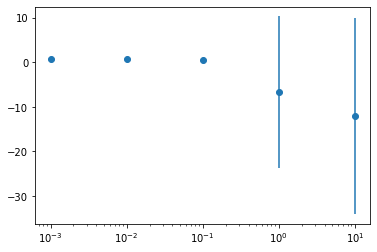

In [137]:
# test with cv k = 10
K = 10 # K Folds
lamb = 10 

test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)
        model = ConcreteNN()
        optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
        epochs = 2000
        loss_over_time = []
        test_loss_over_time = []
        for i in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            target = y_train.unsqueeze(1)
            loss = informed_loss1(X_train, output, target, lamb)
            loss.backward()
            optimizer.step()

        test_r2, test_rmse = eval_model(X_test, y_test)
        train_r2, train_rmse = eval_model(X_train, y_train)
        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)


    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)

plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
print(test_r2_means)

Test with different lambdas and then plot errorplot...

\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot ReLU(|f - (b_0 + b_1\cdot w)|)
\end{align}

In [72]:
# test with cv k = 4
K = 4 # K Folds
lamb = 0.01
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    model = ConcreteNN()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        loss = informed_loss1(X_train, output, target, lamb)
        #loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()


    #plt.figure()
    #plt.plot(loss_over_time)
    #plt.plot(test_loss_over_time)

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)


train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()
print('Train R2 Mean: {}, Train R2 Stdev: {} Train RMSE Mean: {}, Train R2 Stdev: {}'.format(train_r2_mean, train_r2_std, train_rmse_mean, train_rmse_std))
print('Test R2 Mean: {}, Test R2 Stdev: {} Test RMSE Mean: {}, Test R2 Stdev: {}'.format(test_r2_mean, test_r2_std, test_rmse_mean, test_rmse_std))

Train R2 Mean: 0.9353905916213989, Train R2 Stdev: 0.0053011695854365826 Train RMSE Mean: 1.968754529953003, Train R2 Stdev: 0.09107279032468796
Test R2 Mean: 0.820319652557373, Test R2 Stdev: 0.07377374172210693 Test RMSE Mean: 3.0798840522766113, Test R2 Stdev: 0.6790127754211426


[0.8130780458450317, 0.8174673318862915, 0.8157296776771545, 0.6510791778564453, -6.612228870391846, -11.721270561218262]


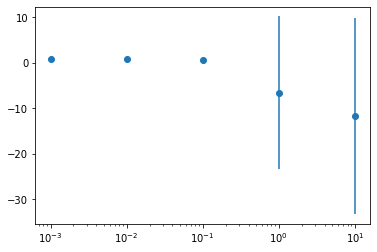

In [138]:
# test with cv k = 10
K = 10 # K Folds
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)
        model = ConcreteNN()
        optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
        epochs = 2000
        loss_over_time = []
        test_loss_over_time = []
        for i in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            target = y_train.unsqueeze(1)
            loss = informed_loss2(X_train, output, target, lamb)
            loss.backward()
            optimizer.step()

        test_r2, test_rmse = eval_model(X_test, y_test)
        train_r2, train_rmse = eval_model(X_train, y_train)
        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)


    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)

plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
print(test_r2_means)

\begin{align}
InformedLoss = MSELoss(output, target) + \lambda\cdot|f - (b_0 + b_1\cdot w)|
\end{align}

In [145]:
# test with cv k = 4
K = 10 # K Folds
lamb = 0.1
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    model = ConcreteNN()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        #loss = informed_loss3(X_train, output, target, lamb)
        loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()


    #plt.figure()
    #plt.plot(loss_over_time)
    #plt.plot(test_loss_over_time)

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)


train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()
print('Train R2 Mean: {}, Train R2 Stdev: {} Train RMSE Mean: {}, Train R2 Stdev: {}'.format(train_r2_mean, train_r2_std, train_rmse_mean, train_rmse_std))
print('Test R2 Mean: {}, Test R2 Stdev: {} Test RMSE Mean: {}, Test R2 Stdev: {}'.format(test_r2_mean, test_r2_std, test_rmse_mean, test_rmse_std))

Train R2 Mean: 0.9319712519645691, Train R2 Stdev: 0.011459430679678917 Train RMSE Mean: 2.0198357105255127, Train R2 Stdev: 0.11146076768636703
Test R2 Mean: 0.8093721270561218, Test R2 Stdev: 0.08625514060258865 Test RMSE Mean: 2.6135287284851074, Test R2 Stdev: 0.7351322174072266


[0.8205771446228027, 0.8142261505126953, 0.8185831904411316, 0.8082209825515747, 0.7188535928726196, 0.43627309799194336]


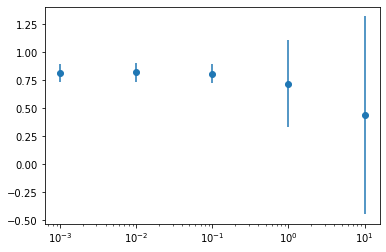

In [147]:
# test with cv k = 10
K = 10 # K Folds
lamb = 10 

test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
train_r2_means = []
train_r2_stds = []
train_rmse_means = [] 
train_rmse_stds = []
test_r2_means = [] 
test_r2_stds = []
test_rmse_means = [] 
test_rmse_stds = []
lambdas = [0, 0.001, 0.01, 0.1, 1, 10]

skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)
        model = ConcreteNN()
        optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
        epochs = 2000
        loss_over_time = []
        test_loss_over_time = []
        for i in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            target = y_train.unsqueeze(1)
            loss = informed_loss3(X_train, output, target, lamb)
            loss.backward()
            optimizer.step()

        test_r2, test_rmse = eval_model(X_test, y_test)
        train_r2, train_rmse = eval_model(X_train, y_train)
        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)


    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

    train_r2_means.append(train_r2_mean)
    train_r2_stds.append(train_r2_std)
    train_rmse_means.append(train_rmse_mean)
    train_rmse_stds.append(train_rmse_std)
    test_r2_means.append(test_r2_mean)
    test_r2_stds.append(test_r2_std)
    test_rmse_means.append(test_rmse_mean) 
    test_rmse_stds.append(test_rmse_std)

plt.errorbar(lambdas, test_r2_means, test_r2_stds, linestyle='None', marker='o')
plt.xscale('log')
print(test_r2_means)